In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import csv 
import time
import sys
import os 

#put your path in possible_paths 
possible_paths = ["..\\utils\\", "../../utils/"]
for path in possible_paths:
    if os.path.isdir(path):
        utils_path = path
        
sys.path.insert(0, utils_path)   

import utils as ut
import fancyplots as fp


C:\Users\marin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#When a library is updated, run
import importlib
importlib.reload(ut)

<module 'utils' from '..\\utils\\utils.py'>

## Load the data

In [3]:
regr_data_dirs = ["../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/",
                  "..\\Classification\\Datasets\\"]
for path in regr_data_dirs:
    if os.path.isdir(path):
        regr_data_dir = path
        print(path)

..\Classification\Datasets\


In [4]:
# Regression1 has only m1 and m2 in all files
#Regression2 has m1 m2 and Mc in the test files, and only m1,m2 in the prediction one
features_names       = ['m1', 'm2', 'Mc']
data_paths           = {}
data_paths['xtest']  = regr_data_dir+'reg1_xtest.csv'
data_paths['ytest']  = regr_data_dir+'reg1_ytest.csv'
data_paths['predicted']  = regr_data_dir+'reg1_prediction.csv'
data_paths['categories']  = regr_data_dir+'reg1_label.csv'
rdl_out = ut.classificationDatasetLoader(data_paths, features_names)
reg1_xtest  = rdl_out['xtest']
reg1_ytest  = rdl_out['ytest']
reg1_label   = rdl_out['categories']
reg1_predicted   = rdl_out['predicted']

data_paths           = {}
data_paths['xtest']  = regr_data_dir+'reg2_xtest.csv'
data_paths['ytest']  = regr_data_dir+'reg2_ytest.csv'
data_paths['predicted']  = regr_data_dir+'reg2_prediction.csv'
data_paths['categories']  = regr_data_dir+'reg2_label.csv'
rdl_out = ut.classificationDatasetLoader(data_paths, features_names)
reg2_xtest  = rdl_out['xtest']
reg2_ytest  = rdl_out['ytest']
reg2_label   = rdl_out['categories']
reg2_predicted   = rdl_out['predicted']

#Insert the recovered by GstLAL Mc in the predicted for reg2, so everything has the same number of features, and simulate our goal
reg2_Mc=reg2_xtest[:,2]
reg2_predicted=np.insert(reg2_predicted, 2, reg2_Mc, axis=1)
#check consistency:
if (len(reg1_xtest)==len(reg1_ytest)==len(reg1_label)==len(reg1_predicted)):
    print("reg1 is ok")
if (len(reg2_xtest)==len(reg2_ytest)==len(reg2_label)==len(reg2_predicted)):
    print("reg2 is ok")

reg1 is ok
reg2 is ok


## Divide in train and testing

In [5]:
pcTrain=0.7
reg1_Ntrain=int(pcTrain*len(reg1_xtest)); reg2_Ntrain=int(pcTrain*len(reg2_xtest));

reg1_xtrain_inj = reg1_ytest[:reg1_Ntrain]
reg1_xtrain_gstlal = reg1_xtest[:reg1_Ntrain]
reg1_xtrain_NN = reg1_predicted[:reg1_Ntrain]
reg1_ytrain = reg1_label[:reg1_Ntrain]

reg1_xtest_inj = reg1_ytest[reg1_Ntrain:]
reg1_xtest_gstlal = reg1_xtest[reg1_Ntrain:]
reg1_xtest_NN = reg1_predicted[reg1_Ntrain:]
reg1_ytest = reg1_label[reg1_Ntrain:]

reg2_xtrain_inj = reg2_ytest[:reg2_Ntrain]
reg2_xtrain_gstlal = reg2_xtest[:reg2_Ntrain]
reg2_xtrain_NN = reg2_predicted[:reg2_Ntrain]
reg2_ytrain = reg2_label[:reg2_Ntrain]

reg2_xtest_inj = reg2_ytest[reg2_Ntrain:]
reg2_xtest_gstlal = reg2_xtest[reg2_Ntrain:]
reg2_xtest_NN = reg2_predicted[reg2_Ntrain:]
reg2_ytest = reg2_label[reg2_Ntrain:]

print("Reg1 training with ",reg1_Ntrain,"samples, testing with ", len(reg1_xtest)-reg1_Ntrain)
print("Reg2 training with ",reg2_Ntrain,"samples, testing with ", len(reg2_xtest)-reg2_Ntrain)

Reg1 training with  4156 samples, testing with  1782
Reg2 training with  4657 samples, testing with  1997


In [96]:
def classify(xtrain, ytrain, xtest1, xtest2, ytest,version="data"):
    clf = RandomForestClassifier()  
    clf.fit(xtrain, np.ravel(ytrain))
    print("Score of ", version," tested on itself:", clf.score(xtest1,ytest))
    print("Score of ", version," tested on injected:", clf.score(xtest2,ytest))


In [98]:
classify(reg1_xtrain_inj, reg1_ytrain, reg1_xtest_inj, reg1_xtest_inj, reg1_ytest, "injected")
classify(reg1_xtrain_gstlal, reg1_ytrain, reg1_xtest_gstlal, reg1_xtest_inj, reg1_ytest, "gstLAL")
classify(reg1_xtrain_inj, reg1_ytrain, reg1_xtest_NN, reg1_xtest_inj, reg1_ytest, "NN")

Score of  injected  tested on itself: 0.9977553310886644
Score of  injected  tested on injected: 0.9977553310886644
Score of  gstLAL  tested on itself: 0.8153759820426487
Score of  gstLAL  tested on injected: 0.7828282828282829
Score of  NN  tested on itself: 0.845679012345679
Score of  NN  tested on injected: 0.9977553310886644


In [130]:
def averageScore(xtrain, ytrain, xtest1, xtest2, ytest,L=100):
    score_itself=[]
    score_inj=[]
    mean_itself=[]
    mean_inj=[]
    std_itself=[]
    std_inj=[]
    trainings=[]
    for i in range(1,L+1):
        clf = RandomForestClassifier()  
        clf.fit(xtrain, np.ravel(ytrain))
        score_itself.append(clf.score(xtest1,ytest))
        score_inj.append(clf.score(xtest2,ytest))
        trainings.append(i)
        mean_itself.append(np.mean(score_itself))
        mean_inj.append(np.mean(score_inj))
        std_itself.append(np.std(score_itself))
        std_inj.append(np.std(score_inj))
    result={}
    result['sc_self'] = score_itself
    result['sc_inj'] = score_inj
    result['m_self'] = mean_itself
    result['m_inj'] = mean_inj
    result['std_self'] = std_itself
    result['std_inj'] = std_inj
    result['trains'] = trainings
    return result

def plotScores(dic, model='trained',save=True, show=True):
    plt.grid()
    plt.xlabel("# trainings"); plt.ylabel("mean score")
    plt.plot(dic['trains'], dic['m_self'])
    if save:
        plt.savefig(model+'mean_score.png',dpi=200,bbox_inches='tight')
    if show:
        plt.show()
    plt.clf()

    plt.grid()
    plt.xlabel("# trainings"); plt.ylabel("score")
    plt.plot(dic['trains'], dic['sc_self'],'o')
    if save:
        plt.savefig(model+'_score.png',dpi=200,bbox_inches='tight')
    if show:
        plt.show()
    plt.clf()
    
def compareScore(dic1, dic2, dic3, name1, name2, name3,save=True, show=True, dataset='reg1'):
    xvalues = [name1, name2, name3]
    yvalues = [dic1['m_self'][-1], dic2['m_self'][-1], dic3['m_self'][-1]]
    errors = [dic1['std_self'][-1], dic2['std_self'][-1], dic3['std_self'][-1]]
    print("Values ", yvalues)
    print("Std ", errors)
    plt.xlabel("origin features"); plt.ylabel("score"); plt.grid()
    plt.errorbar(xvalues, yvalues, errors, fmt='o')
    if save:
        plt.savefig(dataset+'_comparison.png',dpi=200,bbox_inches='tight')
    if show:
        plt.show()
    plt.clf()
    
def compareScoreWWout(dic1, dic2, name1, name2,save=True, show=True, dataset='reg1'):
    xvalues = [name1, name2]
    yvalues = [dic1['m_self'][-1], dic2['m_self'][-1]]
    errors = [dic1['std_self'][-1], dic2['std_self'][-1]]
    print("Values ", yvalues)
    print("Std ", errors)
    plt.xlabel("origin features"); plt.ylabel("score"); plt.grid()
    plt.errorbar(xvalues, yvalues, errors, fmt='o')
    if save:
        plt.savefig(dataset+'_comparisonRecovered.png',dpi=200,bbox_inches='tight')
    if show:
        plt.show()
    plt.clf()


In [118]:
reg1_gstlal= averageScore(reg1_xtrain_gstlal,reg1_ytrain,reg1_xtest_gstlal, reg1_xtest_inj, reg1_ytest,2000)
reg1_NN= averageScore(reg1_xtrain_NN,reg1_ytrain,reg1_xtest_NN, reg1_xtest_inj, reg1_ytest,2000)
reg1_inj= averageScore(reg1_xtrain_inj,reg1_ytrain,reg1_xtest_inj, reg1_xtest_inj, reg1_ytest,2000)

reg2_gstlal= averageScore(reg2_xtrain_gstlal,reg2_ytrain,reg2_xtest_gstlal, reg2_xtest_inj, reg2_ytest,2000)
reg2_NN= averageScore(reg2_xtrain_NN,reg2_ytrain,reg2_xtest_NN, reg2_xtest_inj, reg2_ytest,2000)
reg2_inj= averageScore(reg2_xtrain_inj,reg2_ytrain,reg2_xtest_inj, reg2_xtest_inj, reg2_ytest,2000)


NameError: name 'reg1_inj' is not defined

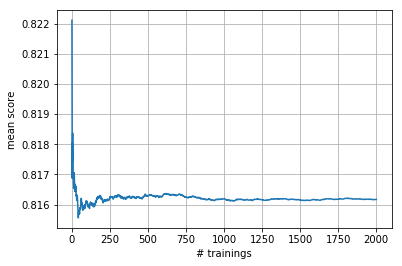

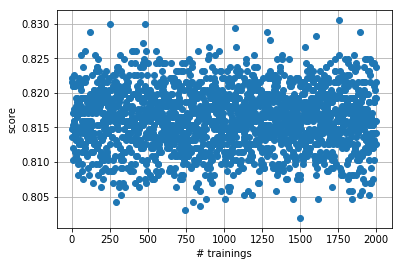

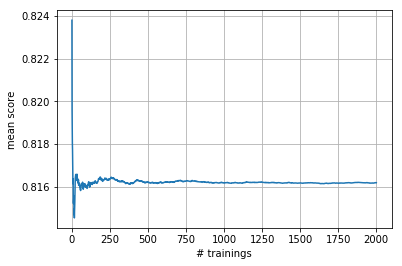

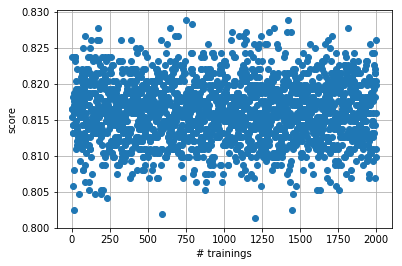

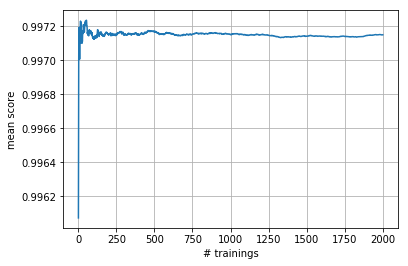

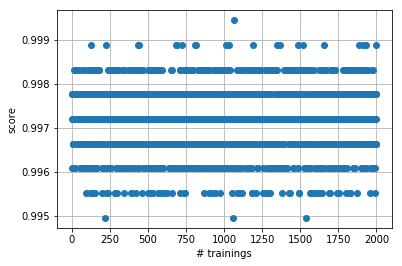

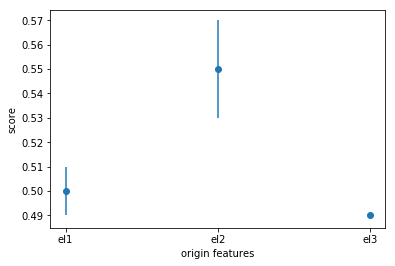

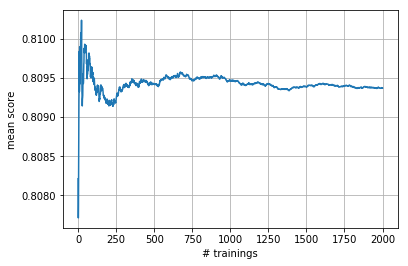

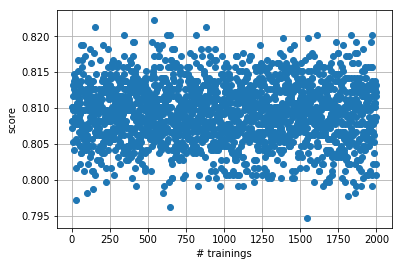

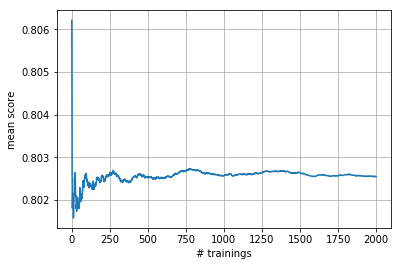

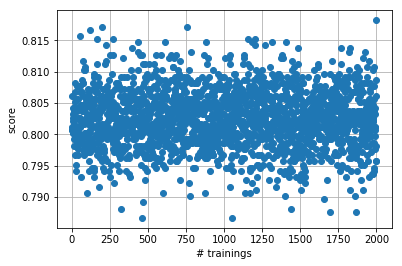

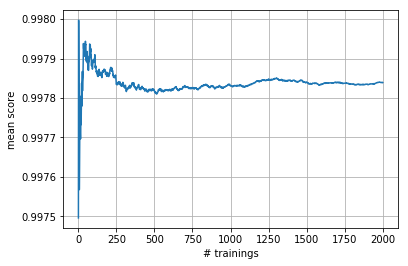

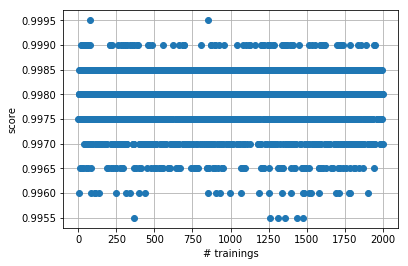

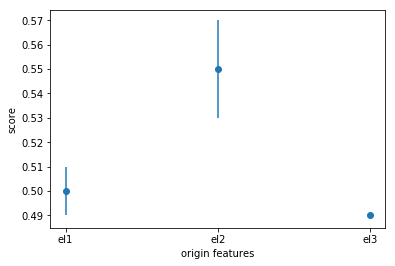

<Figure size 432x288 with 0 Axes>

In [119]:
plotScores(reg1_gstlal, 'reg1_gstlal')
plotScores(reg1_NN, 'reg1_NN')
plotScores(reg1_inj, 'reg1_inj')


plotScores(reg2_gstlal, 'reg2_gstlal')
plotScores(reg2_NN, 'reg2_NN')
plotScores(reg2_inj, 'reg2_inj')
compareScore(reg2_inj, reg2_gstlal, reg2_NN, 'injected', 'gstlal', 'NN', dataset='reg2')

Values  [0.8161728395061728, 0.8161975308641976]
Std  [0.004378528646806719, 0.0043030844581079634]


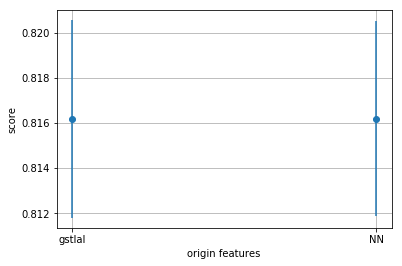

Values  [0.8093710565848774, 0.8025478217325988]
Std  [0.004179439536847991, 0.004534014734751441]


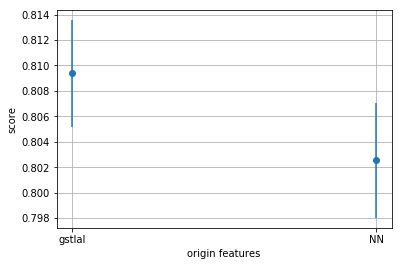

<Figure size 432x288 with 0 Axes>

In [131]:
compareScoreWWout(reg1_gstlal, reg1_NN,'gstlal', 'NN')
compareScoreWWout(reg2_gstlal, reg2_NN,'gstlal', 'NN', dataset='reg2')

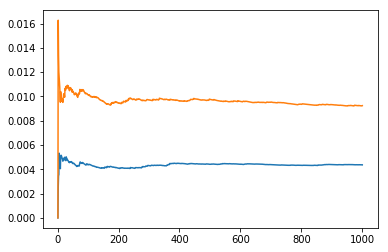

In [106]:
plt.grid()
plt.plot(reg1_gstlal['trains'], reg1_gstlal['std_self'])
plt.plot(reg1_gstlal['trains'], reg1_gstlal['std_inj'])
plt.show()

In [37]:
clf = RandomForestClassifier()
clf.fit(xtrain_NN, ytrain)
print("Predicted tested on predicted: ",clf.score(xtest_NN,ytest))
print("Predicted tested on injected: ",clf.score(xtest_injected,ytest))

Predicted tested on predicted:  0.49524286429644465


C:\Users\marin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 3 

In [6]:
def crossValidation(xtrain, ytrain, xtest, ytest, L=50, trees=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                   features=None, crit=["gini","entropy"]):
    
    score_gini=[]
    score_entropy=[]
    
    std_gini=[]
    std_entropy=[]
    
    for tree in trees:
        inside_score=[]
        print("haciendo tree ",tree)
        for i in range(1,L+1):
            clf = RandomForestClassifier(n_estimators=tree, criterion=crit[0], max_features=None)  
            clf.fit(xtrain, np.ravel(ytrain))
            inside_score.append(clf.score(xtest,ytest))
        score_gini.append(np.mean(inside_score))
        std_gini.append(np.std(inside_score))    

    for tree in trees:
        inside_score=[]
        print("entropy tree ",tree)
        for i in range(1,L+1):
            clf = RandomForestClassifier(n_estimators=tree, criterion=crit[1], max_features=None)  
            clf.fit(xtrain, np.ravel(ytrain))
            inside_score.append(clf.score(xtest,ytest))
        score_entropy.append(np.mean(inside_score))
        std_entropy.append(np.std(inside_score))              
            
    result={}
    result['sc_gini'] = score_gini
    result['std_gini'] = std_gini
    result['sc_ent'] = score_entropy
    result['std_ent'] = std_entropy
    result['trees'] = trees
    return result

In [9]:
#cv_reg1_gstlal = crossValidation(reg1_xtrain_gstlal,reg1_ytrain,reg1_xtest_gstlal, reg1_ytest)
#print("ok gstlal")
cv_reg1_NN = crossValidation(reg1_xtrain_NN,reg1_ytrain,reg1_xtest_NN, reg1_ytest)
print("ok NN")
cv_reg1_inj = crossValidation(reg1_xtrain_inj,reg1_ytrain,reg1_xtest_inj, reg1_ytest)
print("ok injected")

#cv_reg2_gstlal = crossValidation(reg2_xtrain_gstlal,reg2_ytrain,reg2_xtest_gstlal, reg2_ytest)
#print("ok gstlal2")
#cv_reg2_NN = crossValidation(reg2_xtrain_NN,reg2_ytrain,reg2_xtest_NN, reg2_ytest)
#print("ok NN2")
#cv_reg2_inj = crossValidation(reg2_xtrain_inj,reg2_ytrain,reg2_xtest_inj,  reg2_ytest)
#print("ok inj2")

haciendo tree  100
haciendo tree  200
haciendo tree  300
haciendo tree  400
haciendo tree  500
haciendo tree  600
haciendo tree  700
haciendo tree  800
haciendo tree  900
haciendo tree  1000
entropy tree  100
entropy tree  200
entropy tree  300
entropy tree  400
entropy tree  500
entropy tree  600
entropy tree  700
entropy tree  800
entropy tree  900
entropy tree  1000
ok NN
haciendo tree  100
haciendo tree  200
haciendo tree  300
haciendo tree  400
haciendo tree  500
haciendo tree  600
haciendo tree  700
haciendo tree  800
haciendo tree  900
haciendo tree  1000
entropy tree  100
entropy tree  200
entropy tree  300
entropy tree  400
entropy tree  500
entropy tree  600
entropy tree  700
entropy tree  800
entropy tree  900
entropy tree  1000
ok injected


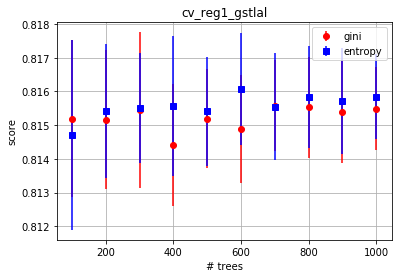

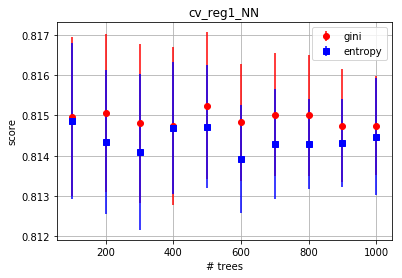

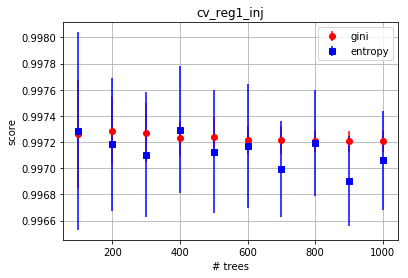

<Figure size 432x288 with 0 Axes>

In [10]:
def drawCV(dic,namefig):
    plt.xlabel("# trees"); plt.ylabel("score"); plt.title(namefig[:-4]);plt.grid()
    plt.errorbar(dic['trees'], dic['sc_gini'],dic['std_gini'], fmt='o',c='red',label='gini')
    plt.errorbar(dic['trees'], dic['sc_ent'],dic['std_ent'], fmt='s',c='blue',label='entropy')
    plt.legend()

    plt.savefig(namefig,dpi=200,bbox_inches='tight')
    plt.show()

    plt.clf()   

drawCV(cv_reg1_gstlal,'cv_reg1_gstlal.png')
drawCV(cv_reg1_NN, 'cv_reg1_NN.png')
drawCV(cv_reg1_inj, 'cv_reg1_inj.png')
#drawCV(cv_reg2_gstlal, 'cv_reg2_gstlal.png')
#drawCV(cv_reg2_NN, 'cv_reg2_NN.png')
#drawCV(cv_reg2_inj, 'cv_reg2_inj.png')


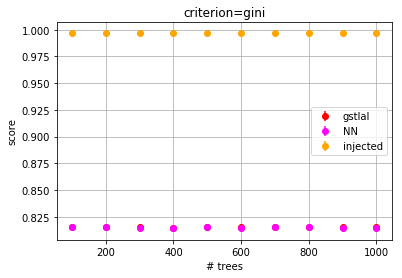

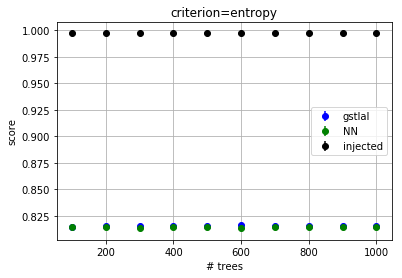

<Figure size 432x288 with 0 Axes>

In [11]:
#mirar la distribucion
def compareCV(dic1,dic2,dic3,name1, name2,name3,namefig):
    plt.xlabel("# trees"); plt.ylabel("score"); plt.title('criterion=gini');plt.grid()
    plt.errorbar(dic1['trees'],dic1['sc_gini'],dic1['std_gini'],fmt='o',c='red',label=name1)
    plt.errorbar(dic2['trees'],dic2['sc_gini'],dic2['std_gini'],fmt='o',c='magenta',label=name2)
    plt.errorbar(dic3['trees'],dic3['sc_gini'],dic3['std_gini'],fmt='o',c='orange',label=name3)
    plt.legend()
    
    plt.savefig(namefig+'gini.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()
    
    plt.xlabel("# trees"); plt.ylabel("score"); plt.title('criterion=entropy');plt.grid()
    plt.errorbar(dic1['trees'],dic1['sc_ent'],dic1['std_ent'],fmt='o',c='blue',label=name1)
    plt.errorbar(dic2['trees'],dic2['sc_ent'],dic2['std_ent'],fmt='o',c='green',label=name2)
    plt.errorbar(dic3['trees'],dic3['sc_ent'],dic3['std_ent'],fmt='o',c='black',label=name3)
    plt.legend()

    plt.savefig(namefig+'ent.png',dpi=200,bbox_inches='tight')
    plt.show()

    plt.clf()
    
compareCV(cv_reg1_gstlal,cv_reg1_NN,cv_reg1_inj, 'gstlal', 'NN', 'injected', 'reg1_cv_comparison')
#compareCV(cv_reg2_gstlal,cv_reg2_NN,cv_reg2_inj, 'gstlal', 'NN', 'injected', 'reg2_cv_comparison')

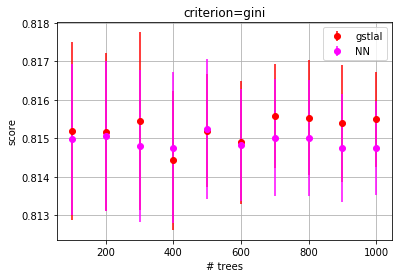

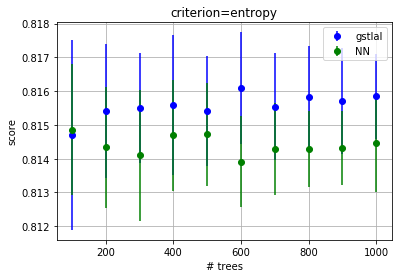

<Figure size 432x288 with 0 Axes>

In [13]:
def compareCV2(dic1,dic2,name1, name2,namefig):
    plt.xlabel("# trees"); plt.ylabel("score"); plt.title('criterion=gini');plt.grid()
    plt.errorbar(dic1['trees'],dic1['sc_gini'],dic1['std_gini'],fmt='o',c='red',label=name1)
    plt.errorbar(dic2['trees'],dic2['sc_gini'],dic2['std_gini'],fmt='o',c='magenta',label=name2)
    plt.legend()
    
    plt.savefig(namefig+'gini.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()
    
    plt.xlabel("# trees"); plt.ylabel("score"); plt.title('criterion=entropy');plt.grid()
    plt.errorbar(dic1['trees'],dic1['sc_ent'],dic1['std_ent'],fmt='o',c='blue',label=name1)
    plt.errorbar(dic2['trees'],dic2['sc_ent'],dic2['std_ent'],fmt='o',c='green',label=name2)
    plt.legend()

    plt.savefig(namefig+'ent.png',dpi=200,bbox_inches='tight')
    plt.show()

    plt.clf()
    
compareCV2(cv_reg1_gstlal,cv_reg1_NN, 'gstlal', 'NN',  'reg1_cv_2comparison')

In [15]:
print("Reg1_NN")
print(cv_reg1_NN)
print("------------------------------------------")
print("Reg1_gstlal")
print(cv_reg1_gstlal)
print("------------------------------------------")
print("Reg1_inh")
print(cv_reg1_inj)
print("------------------------------------------")

Reg1_NN
{'sc_gini': [0.8149719416386084, 0.8150617283950616, 0.814803591470258, 0.8147474747474746, 0.8152413019079685, 0.8148260381593715, 0.815016835016835, 0.8150056116722783, 0.8147474747474748, 0.8147474747474748], 'std_gini': [0.0019698168735747517, 0.0019509259337949008, 0.0019712551512314444, 0.001965335500771937, 0.0018255107170682355, 0.001456831626759165, 0.001525549390576533, 0.0015041375467768584, 0.0013956715202433046, 0.0012276102279573738], 'sc_ent': [0.8148597081930415, 0.8143322109988776, 0.8140965207631874, 0.8146913580246913, 0.8147250280583613, 0.8139169472502806, 0.8142873176206509, 0.814287317620651, 0.8143097643097643, 0.8144781144781145], 'std_ent': [0.001936929472934203, 0.0017887419949858515, 0.0019375796892984545, 0.0016352609445687252, 0.0015197585526204923, 0.0013468013468013495, 0.0013672687208247, 0.0011246328878188108, 0.0010953547304120652, 0.001450375755703714], 'trees': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
----------------------------

In [23]:
#Changedepth TEST2
depthoftrees=[2,5,10,None]
accuracyofdepth=np.zeros(len(depthoftrees))
i=0
for depth in depthoftrees:
    clf = RandomForestClassifier(max_depth=depth, random_state=5)
    clf.fit(xtrain, ytrain)
    accuracyofdepth[i]=clf.score(xtest, ytest)
    i=i+1

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated

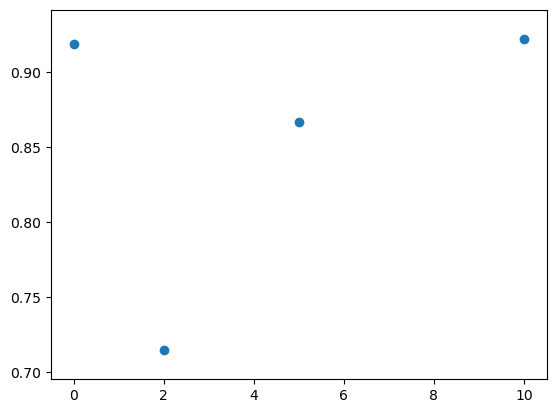

[0.7146 0.8668 0.9224 0.9186]


In [24]:
depthoftrees=[2,5,10,0]
plt.scatter(depthoftrees,accuracyofdepth); plt.show(); print(accuracyofdepth)

In [29]:
prob=clf.predict_proba([xtest[0]])

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


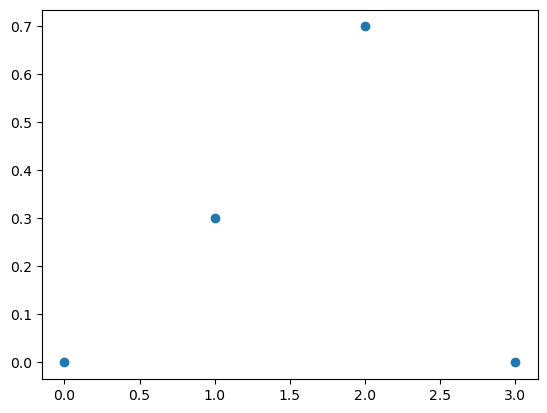

In [42]:
plt.plot([0,1,2,3],prob[0],'o'); plt.show()

In [46]:
#New test: what is the second option of the classification
#For every possible category for classification, probability for each category
#First part the testing set
in0=[]; in1=[]; in2=[]; in3=[]
for i in range(0,len(ytest)):
    if (ytest[i]==0):
        in0.append(i)
    elif (ytest[i]==1):
        in1.append(i)
    elif (ytest[i]==2):
        in2.append(i)
    else:
        in3.append(i)

In [47]:
probs=clf.predict_proba(xtest)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [53]:
plot1=[]; plot2=[]; plot3=[]; plot0=[]
for i in in0:
    plot0.append(probs[i])
for i in in1:
    plot1.append(probs[i])
for i in in2:
    plot2.append(probs[i])
for i in in3:
    plot3.append(probs[i])

1000


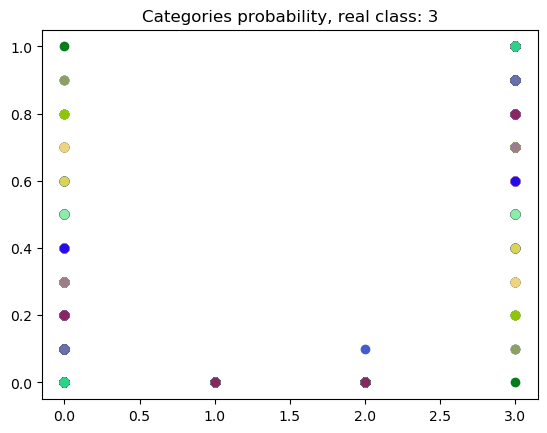

In [70]:
print(len(plot3))
for i in range(0,len(plot3)):
    plt.plot([0,1,2,3],plot3[i],'o',color=np.random.rand(3,));
plt.title('Categories probability, real class: 3'); plt.show()

In [71]:
pred=clf.predict(xtest)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [74]:
predof0=[]; predof1=[]; predof2=[]; predof3=[];
for i in in0:
    predof0.append(pred[i])
for i in in1:
    predof1.append(pred[i])
for i in in2:
    predof2.append(pred[i])
for i in in3:
    predof3.append(pred[i])

In [80]:
count_arr = np.bincount(predof3); print((count_arr[3])/len(predof3))

0.874


In [7]:
#With the first attempt to be conditional
xtrain=generateEvents(10000)
ytrain=categorize_cond(xtrain,talk=True)
xtest=generateEvents(5000)
ytest=categorize_cond(xtest)

No NS  49.84 %
Has NS, no remnant:  31.05 %
Has NS, yes remnant:  19.11 %


In [8]:
clf = RandomForestClassifier(random_state=5)
clf.fit(xtrain, ytrain)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In cat 0: 2547


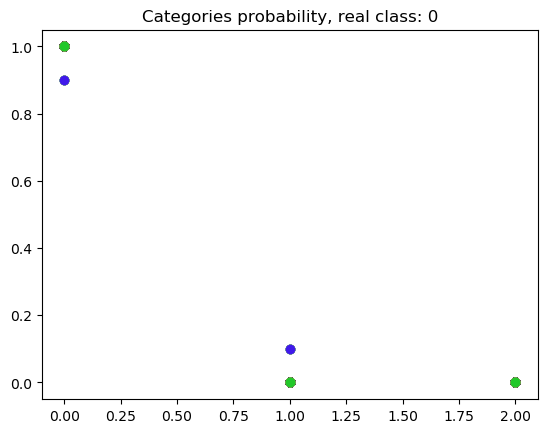

In cat 1: 1478


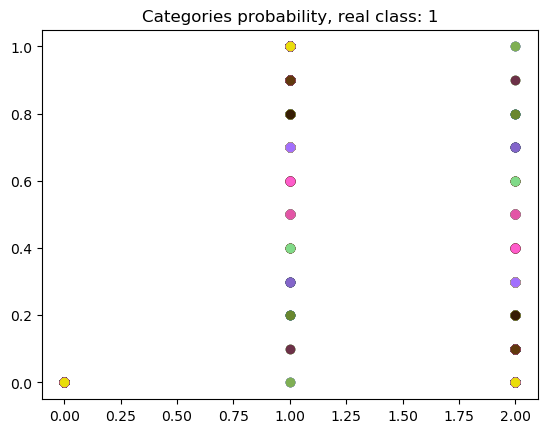

In cat 2: 975


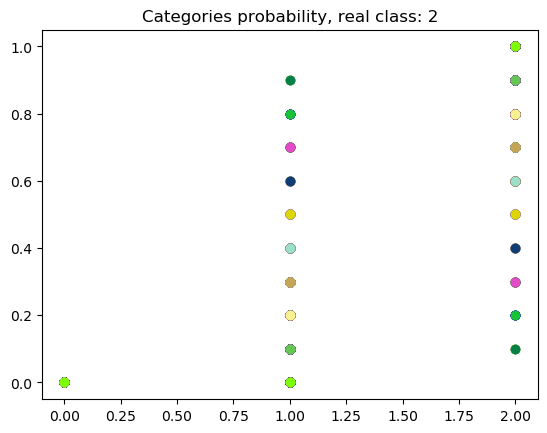

Accuracy class 0:  1.0
Accuracy class 1:  0.9682002706359946
Accuracy class 2:  0.877948717948718


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [13]:
#For every possible category for classification, probability for each category
#First part the testing set
in0=[]; in1=[]; in2=[]; 
for i in range(0,len(ytest)):
    if (ytest[i]==0):
        in0.append(i)
    elif (ytest[i]==1):
        in1.append(i)
    elif (ytest[i]==2):
        in2.append(i)
probs=clf.predict_proba(xtest)
plot1=[]; plot2=[]; plot0=[]
for i in in0:
    plot0.append(probs[i])
for i in in1:
    plot1.append(probs[i])
for i in in2:
    plot2.append(probs[i])
    
print('In cat 0:',len(plot0))
for i in range(0,len(plot0)):
    plt.plot([0,1,2],plot0[i],'o',color=np.random.rand(3,));
plt.title('Categories probability, real class: 0'); plt.show()
plt.clf()
print('In cat 1:',len(plot1))
for i in range(0,len(plot1)):
    plt.plot([0,1,2],plot1[i],'o',color=np.random.rand(3,));
plt.title('Categories probability, real class: 1'); plt.show()
plt.clf()
print('In cat 2:',len(plot2))
for i in range(0,len(plot2)):
    plt.plot([0,1,2],plot2[i],'o',color=np.random.rand(3,));
plt.title('Categories probability, real class: 2'); plt.show()
plt.clf()

pred=clf.predict(xtest)
predof0=[]; predof1=[]; predof2=[];
for i in in0:
    predof0.append(pred[i])
for i in in1:
    predof1.append(pred[i])
for i in in2:
    predof2.append(pred[i])
print('Accuracy class 0: ',(np.bincount(predof0)[0])/len(predof0))
print('Accuracy class 1: ',(np.bincount(predof1)[1])/len(predof1))
print('Accuracy class 2: ',(np.bincount(predof2)[2])/len(predof2))

In [26]:
pNS=[]
success=0
for i in range(0,len(probs)):
    pNS.append(probs[i][1]+probs[i][2])
    if(pNS[i]>0.2 and ytest[i]>0):
        success=success+1
    elif (pNS[i]<0.2 and ytest[i]==0):
        success=success+1
print('Accuracy classifying bodies: ', success/len(ytest))


Accuracy classifying bodies:  1.0
